In [1]:
from SphericalSIREN.inr import SphericalINR, train
from SphericalSIREN.sampling import sample_s2
from SphericalSIREN.utils import *
from chebychev import Chebyshev
from plotting import plot_sphere

In [2]:
import numpy as np
import pyshtools
import matplotlib.pyplot as plt

import torch_harmonics as th
import torch
from sklearn.preprocessing import MinMaxScaler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
L = 50
phi, theta, (nlon, nlat) = sample_s2(L, sampling = "gl", torch_tensor = True)

In [5]:
coefficients = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 200)

In [6]:
world_map = coefficients.expand(lon = phi.numpy().flatten(), colat = theta.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat, nlon)

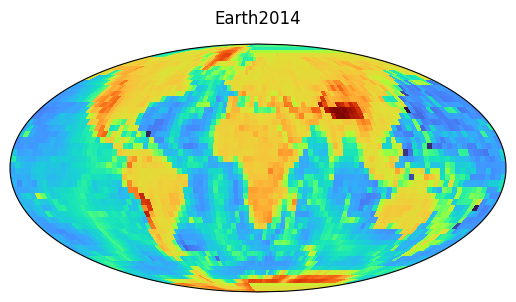

In [ ]:
plot_sphere(world_map, molweide=True, cmap = "turbo", title = "Earth2014")
plt.show()

In [8]:
scaler = MinMaxScaler()
world_map_scaled = scaler.fit_transform(world_map)

X = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()
y = torch.tensor(world_map_scaled.copy()).flatten().unsqueeze(1).float()

# Move tensors to the selected device
X = X.to(device)
y = y.to(device)

In [ ]:
shinr = SphericalINR(

    L0 = 15, 
    Q = 2,
    hidden_features = 100, 
    activation = Chebyshev(order = 5, alpha = .5),
    first_activation=Chebyshev(order = 50, alpha = .3),
    device=device,
    spectral_norm=True,
    bias=True, 
)


loss = train(
    model = shinr, 
    x = X, 
    y = y, 
    epochs = 500,
    batch_size=512,
    optimizer = torch.optim.AdamW(shinr.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(),
    device=device
)

In [80]:
L_test = 50
phi_test, theta_test, (nlon, nlat) = sample_s2(L_test, sampling = "gl", torch_tensor = True)
X_test = torch.stack([theta_test.flatten(), phi_test.flatten()], dim=-1).float()

pred = shinr(X_test).detach().cpu().numpy().reshape(nlat, nlon)
# pred = scaler.inverse_transform()

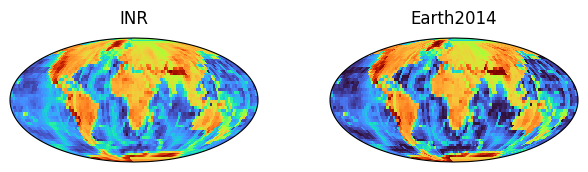

In [81]:
fig = plt.figure()
subfigs = fig.subfigures(1, 2)

plot_sphere(pred, molweide=True, cmap = "turbo", title = "INR", fig = subfigs[0])
plot_sphere(world_map_scaled, molweide=True, cmap = "turbo", title = "Earth2014", fig = subfigs[1])
plt.show()